In [1]:
from pointnet2_benny import pointnet2_cls_ssg
from sklearn.metrics import *
from tqdm import tqdm

from final_models_explainability.get_predictions import *

In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [3]:
subject_list = find_subjects_parallel(data_path)
    

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout/idaSearch_3_19_2025.csv']


In [4]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

In [5]:
print(f"Total holdout subjects: {len(subject_list)}\n")
print(f"Total CN: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 0])}\n")
print(f"Total MCI: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 1])}\n")

Total holdout subjects: 35

Total CN: 12

Total MCI: 23



In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pred_class, output, _ = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        data.append(subject.data['lhcampus_pointcloud_aligned'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/pointnet_eval.npz', true, pred_probs, pred_classes, data)
    

 57%|█████▋    | 20/35 [01:16<00:57,  3.80s/it]


KeyboardInterrupt: 

              precision    recall  f1-score   support

          CN       0.51      0.73      0.60        60
         MCI       0.82      0.63      0.72       115

    accuracy                           0.67       175
   macro avg       0.67      0.68      0.66       175
weighted avg       0.71      0.67      0.68       175

roc_auc: 0.6840579710144927


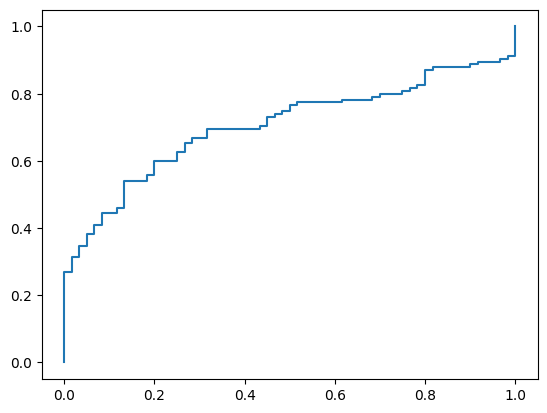

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

plt.plot(fpr, tpr)

plt.show()

Evaluate volumes gbdt

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

for subject in subject_list:

    pred_class, output, _ = get_volumes_prediction(subject.data['volumes'])

    data.append(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/volumes_eval.npz', true, pred_probs, pred_classes, data)

              precision    recall  f1-score   support

          CN       0.00      0.00      0.00        12
         MCI       0.66      1.00      0.79        23

    accuracy                           0.66        35
   macro avg       0.33      0.50      0.40        35
weighted avg       0.43      0.66      0.52        35

roc_auc: 0.5


/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/.venv/lib/python3.12/site-packages/sklearn/met

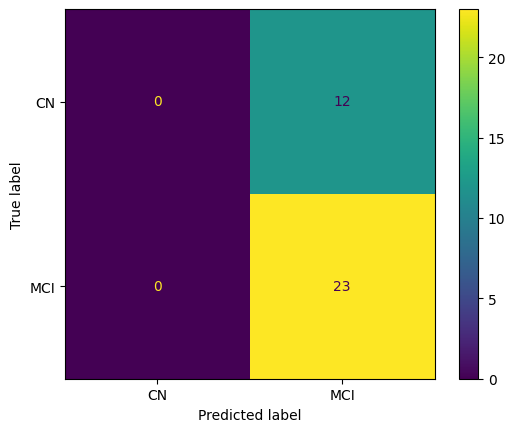

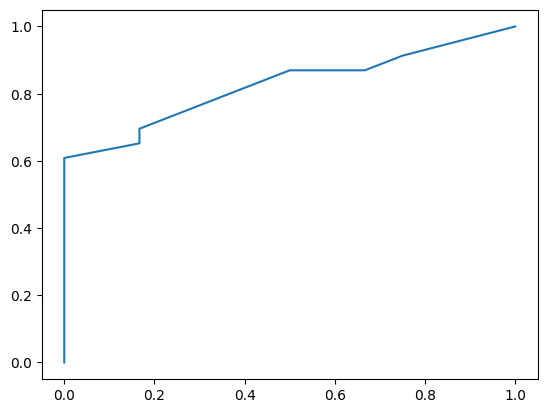

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

plt.plot(fpr, tpr)

plt.show()

Evaluate scores gbdt

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

for subject in subject_list:

    pred_class, output = get_scores_prediction(subject.data['scores'])

    data.append(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scores_eval.npz', true, pred_probs, pred_classes, data)

              precision    recall  f1-score   support

          CN       0.59      0.83      0.69        12
         MCI       0.89      0.70      0.78        23

    accuracy                           0.74        35
   macro avg       0.74      0.76      0.74        35
weighted avg       0.79      0.74      0.75        35

roc_auc: 0.7644927536231885


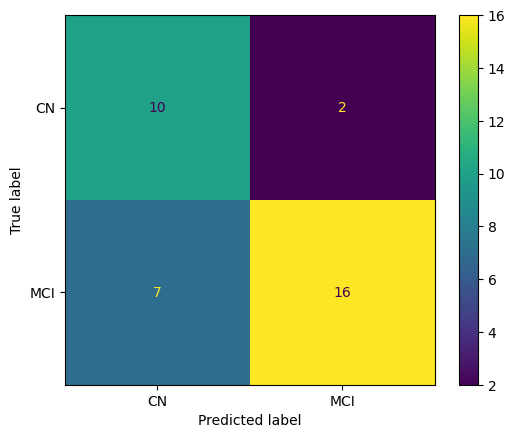

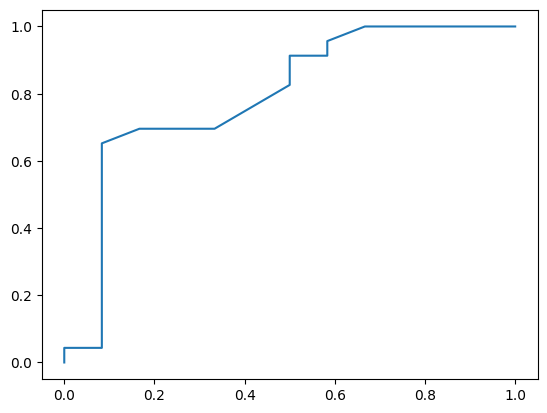

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

plt.plot(fpr, tpr)

plt.show()

Evaluate ensemble with scores

In [ ]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cpu')

    volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

    scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

    prediction = get_ensemble_prediction_avg(pointnet_output, volumes_output, scores_output, scores=True)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

In [ ]:
true = []
pred_probs = []
pred_classes = []

models_used = []

for subject in subject_list:

    pred_research_group, pred_class, output, model = get_ensemble_prediction_maxprob(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

    models_used.append(model)

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()